<a href="https://colab.research.google.com/github/lilhast1/viproject/blob/main/teka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import nbformat

path = 'teka.ipynb'  # change if needed
nb = nbformat.read(path, as_version=nbformat.NO_CONVERT)

# Safely remove metadata.widgets
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']
    print("Removed corrupted 'widgets' metadata.")

# Save the cleaned notebook
nbformat.write(nb, path)
print("Notebook metadata cleaned and saved.")


Notebook metadata cleaned and saved.


# Cyber Threat Intelligence project

In [17]:
# deletion of unneeded content
import shutil
import os
# %cd ../
# gets loaded unnecessarilly so I delete it

folder_path = 'sample_data'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted folder: {folder_path}")
else:
    print(f"Folder not found: {folder_path}")


/content
Deleted folder: sample_data


In [18]:
# Clone the entire repo
!git clone https://github.com/lilhast1/viproject.git

# Change directory to the repo
%cd viproject


fatal: destination path 'viproject' already exists and is not an empty directory.
/content/viproject


## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata

### Helper functions for processing

In [2]:
def df_info(df):
    print(f"Dataset shape: {df.shape}")
    print(f"Label distribution:\n{df['label'].value_counts()}")
    print(f"Label distribution (percentage):\n{df['label'].value_counts(normalize=True) * 100}")

In [3]:
def get_text_stats(text):
    """Calculate various text statistics"""
    # Count words (simple split on whitespace)
    words = str(text).split()
    word_count = len(words)

    # Count characters
    char_count = len(str(text))

    # Count sentences (rough approximation)
    sentence_count = len(re.split(r'[.!?]+', str(text))) - 1
    sentence_count = max(1, sentence_count)  # Ensure at least 1 sentence

    # Average word length
    avg_word_length = np.mean([len(word) for word in words]) if words else 0

    # Average sentence length in words
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    return {
        'word_count': word_count,
        'char_count': char_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

In [4]:
def text_len_dist(stats):
    plt.figure(figsize=(12, 6))
    sns.histplot(stats['word_count'], bins=30, kde=True)
    plt.title('Distribution of Text Length (Word Count)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.axvline(stats['word_count'].median(), color='red', linestyle='--', label=f'Median: {stats["word_count"].median():.1f}')
    plt.axvline(stats['word_count'].mean(), color='green', linestyle='--', label=f'Mean: {stats["word_count"].mean():.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:

# Step 1.1: Normalize URLs
def normalize_urls(text):
    """
    Normalize URLs to a standard format
    Options:
    1. Replace all URLs with a token like [URL]
    2. Keep domain only
    3. Remove completely
    """
    # Option 1: Replace URLs with [URL] token
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('[URL]', text)

    # Option 2: Keep domain name only (uncomment if preferred)
    # def replace_with_domain(match):
    #     url = match.group(0)
    #     domain_match = re.search(r'(?:https?://)?(?:www\.)?([^/]+)', url)
    #     if domain_match:
    #         return f"[{domain_match.group(1)}]"
    #     return "[URL]"
    # return url_pattern.sub(replace_with_domain, text)

    # Option 3: Remove URLs completely (uncomment if preferred)
    # return url_pattern.sub('', text)

In [6]:

# Step 1.2: Standardize different quote types
def standardize_quotes(text):
    """
    Standardize all quotation marks to straight double quotes (")
    """
    # List of quote characters to normalize
    quotes = ["'", "'", '`', '´', '"', '"', '„', '‟', '«', '»', '‹', '›', '“', '”']

    # Replace all opening/closing quotes with standard double quotes
    for quote in quotes:
        text = text.replace(quote, '"')

    # Replace single quotes with standard single quote
    text = text.replace(''', "'")
    text = text.replace(''', "'")

    return text

In [7]:
def normalize_punctuation(text):
    """
    Normalize punctuation marks and spacing around them
    """
    # Normalize unicode punctuation to ASCII equivalents where possible
    text = unicodedata.normalize('NFKD', text)

    # Standardize dashes
    text = re.sub(r'—|–|‐|‒|―|⁃', '-', text)

    return text

In [8]:

def lowercase_text(text):
    return text.lower()

def remove_extra_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text

In [9]:
def preprocess_text(text):
    # Apply each preprocessing step
    text = normalize_urls(text)
    text = standardize_quotes(text)
    text = normalize_punctuation(text)
    text = lowercase_text(text)
    text = remove_extra_whitespace(text)

    return text

## Datasets

### LADDER dataset - CTI

In [25]:
ladder_smthn_dev = pd.read_csv('LADDER_dataset/dev.csv', sep='\t')
ladder_train = pd.read_csv('LADDER_dataset/train.csv', sep='\t')
ladder_test = pd.read_csv('LADDER_dataset/test.csv', sep='\t')

In [26]:
merged_ladder = pd.concat([ladder_train, ladder_test, ladder_smthn_dev], ignore_index=True)

In [27]:
df_info(merged_ladder)

Dataset shape: (3444, 2)
Label distribution:
label
1    1722
0    1722
Name: count, dtype: int64
Label distribution (percentage):
label
1    50.0
0    50.0
Name: proportion, dtype: float64


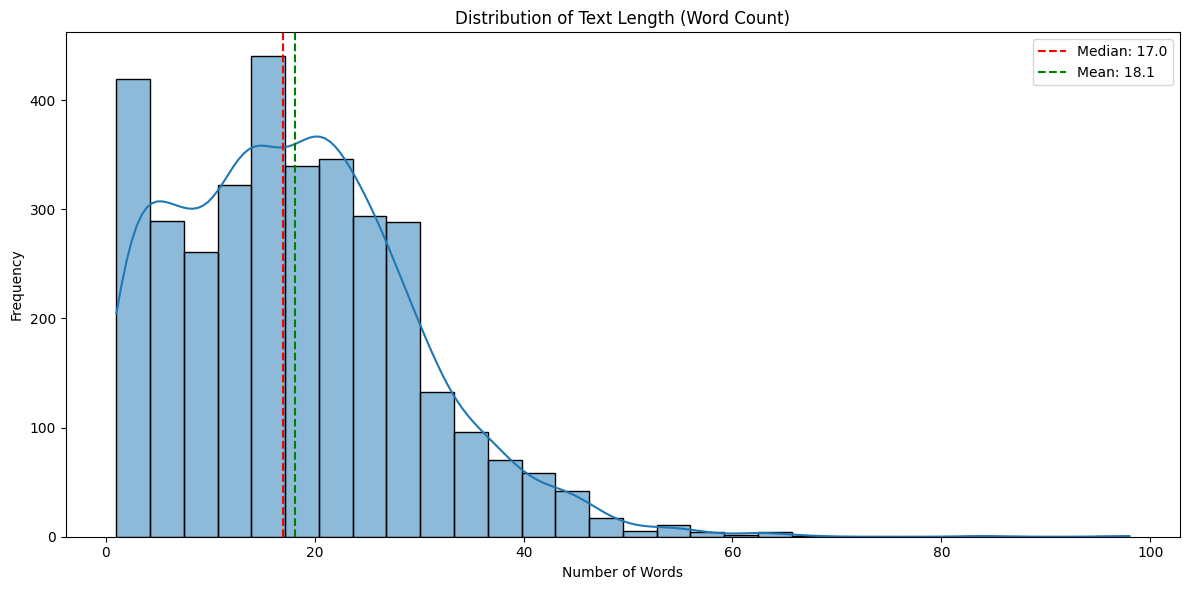

In [28]:
ladder_stats = pd.DataFrame(merged_ladder['text'].apply(get_text_stats).tolist())
text_len_dist(ladder_stats)

In [29]:
merged_ladder['text'] = merged_ladder['text'].apply(preprocess_text)

merged_ladder.to_csv('LADDER_preprocessing/ladder_preprocessed.csv', index=False)

### Social Media dataset

In [30]:
soc_media = pd.read_csv('Social_media_dataset_preprocessing/social_media.csv')
soc_media['label'] = 0
soc_media = soc_media.rename(columns={'message': 'text'})


In [31]:
df_info(soc_media)

Dataset shape: (63018, 2)
Label distribution:
label
0    63018
Name: count, dtype: int64
Label distribution (percentage):
label
0    100.0
Name: proportion, dtype: float64


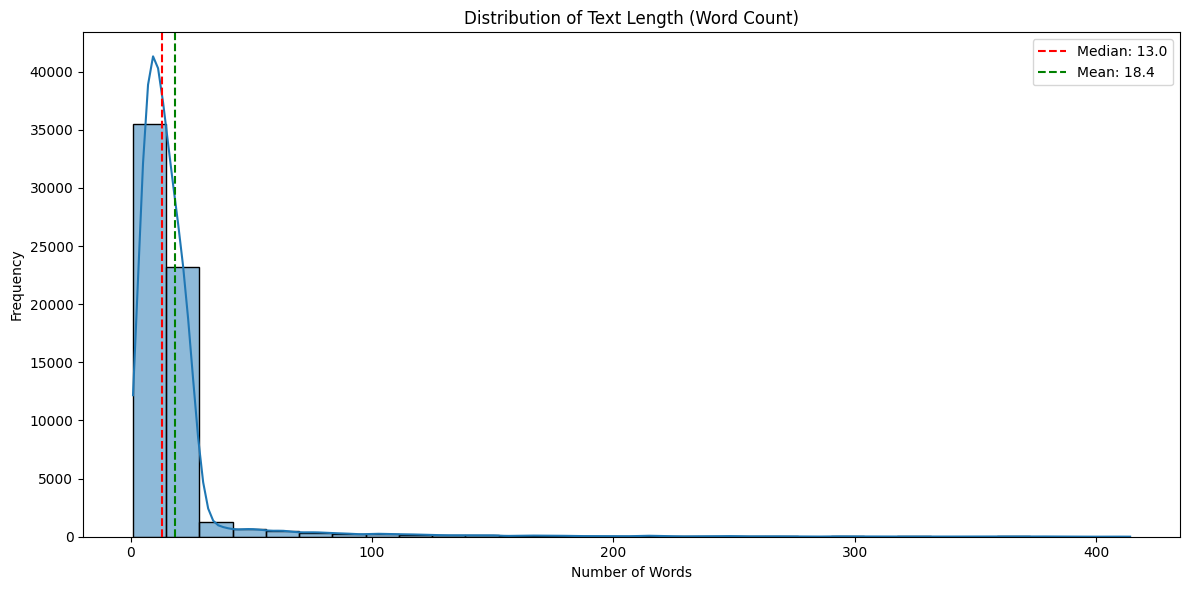

In [32]:
soc_media_stats = pd.DataFrame(soc_media['text'].apply(get_text_stats).tolist())
text_len_dist(soc_media_stats)

Dataset shape: (1576, 2)
Label distribution:
label
0    1576
Name: count, dtype: int64
Label distribution (percentage):
label
0    100.0
Name: proportion, dtype: float64


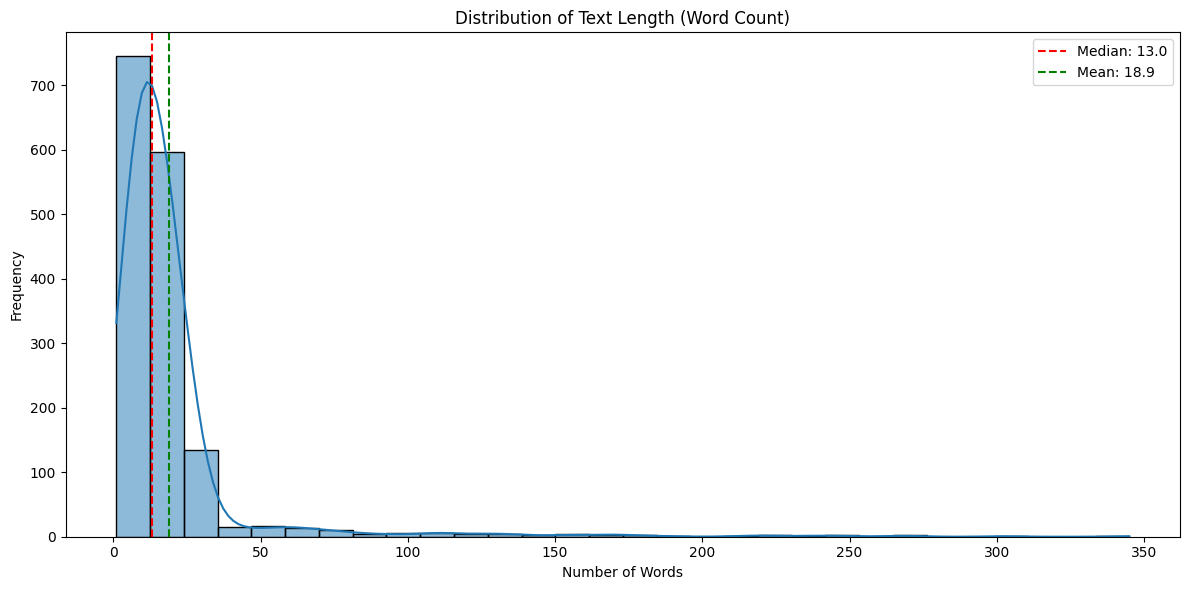

In [33]:
soc_media_skraceno = soc_media.iloc[::40]
df_info(soc_media_skraceno)
stats = pd.DataFrame(soc_media_skraceno['text'].apply(get_text_stats).tolist())
text_len_dist(stats)

In [34]:
df = pd.concat([merged_ladder, soc_media_skraceno], ignore_index=True)

Dataset shape: (5020, 2)
Label distribution:
label
0    3298
1    1722
Name: count, dtype: int64
Label distribution (percentage):
label
0    65.697211
1    34.302789
Name: proportion, dtype: float64


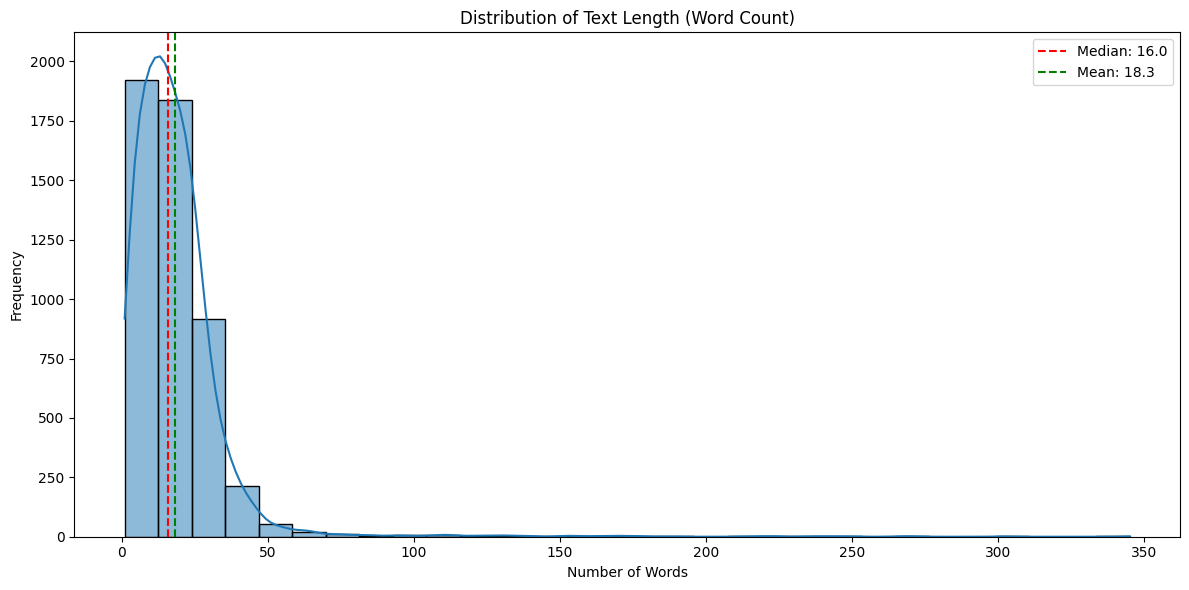

In [35]:
df_info(df)
stats = pd.DataFrame(df['text'].apply(get_text_stats).tolist())
text_len_dist(stats)

In [36]:
df.to_csv('merged_Social_Media_LADDER/ladder_social_media.csv', index=False)

df.iloc[241]

,241
text,"""hi"", ""ask"" - enable and disable mobile internet;"
label,1


## Preprocesing

In [37]:
df.describe()

,label
count,5020.000000
mean,0.343028
std,0.474768
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [38]:
df.tail(10)

,text,label
5010,Remember me??? Full video is on my yt channel ...,0
5011,Im in my DIY era We are having a go at renovat...,0
5012,My valentine for 13 years now CRAZY how time f...,0
5013,What if optimizing for the present means also ...,0
5014,"Transported to Japan for the night, at The arc...",0
5015,Florida we love you,0
5016,We are always continuously evolving and its es...,0
5017,A magical morning at Bow Lake. beautiful skies...,0
5018,This is your sign to slow down and enjoy the l...,0
5019,BMW i8 SIGN up for IG Video GUIDES and learn h...,0


In [39]:
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer

# For more details - https://huggingface.co/bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [40]:
MAX_LENGTH = 512

encoded_inputs = tokenizer(
    df['text'].tolist(),          # List of sentences
    padding='max_length',         # Pad to MAX_LENGTH
    truncation=True,              # Truncate to MAX_LENGTH
    max_length=MAX_LENGTH,
    return_attention_mask=True,   # Return attention mask
    return_tensors=None           # Return Python lists for now (easier to add to df)
                                  # Use 'pt' or 'tf' if directly feeding to model
)

In [41]:
df['input_ids'] = encoded_inputs['input_ids']
df['attention_mask'] = encoded_inputs['attention_mask']
df['token_type_ids'] = encoded_inputs['token_type_ids']


In [42]:
df.head()

,text,label,input_ids,attention_mask,token_type_ids
0,using the device accelerometer sensor it imple...,1,"[101, 2478, 1996, 5080, 16222, 12260, 21716, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,when the malware is first started on the devic...,1,"[101, 2043, 1996, 15451, 8059, 2003, 2034, 231...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,then it will ask for the accessibility service...,1,"[101, 2059, 2009, 2097, 3198, 2005, 1996, 2366...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"after the user grants the requested privilege,...",1,"[101, 2044, 1996, 5310, 8624, 1996, 7303, 1429...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,it also disables play protect (google’s preins...,1,"[101, 2009, 2036, 4487, 19150, 2015, 2377, 404...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [43]:
print(df)

                                                   text  label  \
0     using the device accelerometer sensor it imple...      1   
1     when the malware is first started on the devic...      1   
2     then it will ask for the accessibility service...      1   
3     after the user grants the requested privilege,...      1   
4     it also disables play protect (google’s preins...      1   
...                                                 ...    ...   
5015                                Florida we love you      0   
5016  We are always continuously evolving and its es...      0   
5017  A magical morning at Bow Lake. beautiful skies...      0   
5018  This is your sign to slow down and enjoy the l...      0   
5019  BMW i8 SIGN up for IG Video GUIDES and learn h...      0   

                                              input_ids  \
0     [101, 2478, 1996, 5080, 16222, 12260, 21716, 1...   
1     [101, 2043, 1996, 15451, 8059, 2003, 2034, 231...   
2     [101, 2059, 2009, 2097, 

In [44]:
input_ids_tensor = torch.tensor(df['input_ids'].tolist())
attention_mask_tensor = torch.tensor(df['attention_mask'].tolist())
token_type_ids_tensor = torch.tensor(df['token_type_ids'].tolist())
labels_tensor = torch.tensor(df['label'].tolist())

In [45]:
print("\nPyTorch Tensors:")
print(f"Input IDs Tensor shape: {input_ids_tensor.shape}")
print(f"Attention Mask Tensor shape: {attention_mask_tensor.shape}")
print(f"Labels Tensor shape: {labels_tensor.shape}")


PyTorch Tensors:
Input IDs Tensor shape: torch.Size([5020, 512])
Attention Mask Tensor shape: torch.Size([5020, 512])
Labels Tensor shape: torch.Size([5020])


## BERT

In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# --- 0. Configuration ---
MODEL_NAME = 'bert-base-uncased' # Should be the same as used for tokenization
MAX_LENGTH = 128                 # Should be the same as used for tokenization
BATCH_SIZE = 16                  # Adjust based on your GPU memory
EPOCHS = 3                       # Number of training epochs
LEARNING_RATE = 2e-5             # Common learning rate for BERT fine-tuning
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# --- 2. Tokenize (if not already done, or to ensure consistency) ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

encoded_inputs = tokenizer(
    df['text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='pt' # Return PyTorch tensors directly
)

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
labels = torch.tensor(df['label'].values)

# --- 3. Create PyTorch Datasets and DataLoaders ---
dataset = TensorDataset(input_ids, attention_mask, labels)

# Split into training and validation (e.g., 80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 4. Load Pre-trained BERT Model for Sequence Classification ---
# num_labels=2 because we have binary classification (0 or 1)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, # Number of output labels (0 and 1)
    output_attentions=False, # Optional: set to True if you want attentions
    output_hidden_states=False # Optional: set to True if you want hidden states
)
model.to(DEVICE)

# --- 5. Define Optimizer and Learning Rate Scheduler ---
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Default value in run_glue.py
    num_training_steps=total_steps
)

# --- 6. Training Loop ---
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train() # Set model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch_num, batch in enumerate(dataloader):
        # Unpack batch and move to device
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]

        model.zero_grad() # Clear previously calculated gradients

        # Forward pass
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels # Model calculates loss internally if labels are provided
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate

        # Store predictions and labels for metrics
        preds = torch.argmax(logits, dim=1).flatten()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

        if (batch_num + 1) % 20 == 0 or batch_num == len(dataloader) -1 : # Print every 20 batches
            print(f'  Batch {batch_num+1:>5,}  of  {len(dataloader):>5,}. Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / len(dataloader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_train_loss, train_accuracy, train_f1

# --- 7. Evaluation Function ---
def evaluate(model, dataloader, device):
    model.eval() # Set model to evaluation mode
    total_eval_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Deactivate autograd for evaluation
        for batch in dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]

            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                labels=b_labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = total_eval_loss / len(dataloader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted') # Use 'binary' if classes are imbalanced and you care about the positive class F1
    return avg_val_loss, val_accuracy, val_f1

# --- 8. Start Training and Evaluation ---
best_val_accuracy = 0
training_stats = []

for epoch_i in range(EPOCHS):
    print(f"\n======== Epoch {epoch_i + 1} / {EPOCHS} ========")
    print("Training...")
    avg_train_loss, train_acc, train_f1 = train_epoch(model, train_dataloader, optimizer, scheduler, DEVICE)
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}")

    print("\nRunning Validation...")
    avg_val_loss, val_acc, val_f1 = evaluate(model, val_dataloader, DEVICE)
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Training Acc.': train_acc,
        'Training F1': train_f1,
        'Valid. Loss': avg_val_loss,
        'Valid. Acc.': val_acc,
        'Valid. F1': val_f1
    })

    # Save the best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        # torch.save(model.state_dict(), f'{MODEL_NAME}-best-model.pt')
        # print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")


print("\nTraining complete!")
print("Training Statistics:")
for stat in training_stats:
    print(stat)

# --- 9. (Optional) Save the fine-tuned model and tokenizer ---
# model.save_pretrained("./my_bert_classifier")
# tokenizer.save_pretrained("./my_bert_classifier")
# print("Model and tokenizer saved to ./my_bert_classifier")

# --- 10. (Optional) Make predictions on new data ---
# def predict(texts, model, tokenizer, device, max_length=128):
#     model.eval()
#     encoded_review = tokenizer(
#         texts,
#         padding='max_length',
#         truncation=True,
#         max_length=max_length,
#         return_attention_mask=True,
#         return_tensors='pt'
#     )
#     input_ids = encoded_review['input_ids'].to(device)
#     attention_mask = encoded_review['attention_mask'].to(device)

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         logits = outputs.logits

#     probs = torch.softmax(logits, dim=1)
#     predictions = torch.argmax(probs, dim=1)
#     return predictions.cpu().numpy(), probs.cpu().numpy()

# # Example new texts
# new_texts = [
#     "This product is absolutely fantastic!",
#     "I am very disappointed with the quality.",
#     "It's an okay experience, nothing special."
# ]
# predictions, probabilities = predict(new_texts, model, tokenizer, DEVICE, MAX_LENGTH)
# for text, pred, prob in zip(new_texts, predictions, probabilities):
#     print(f"\nText: {text}")
#     print(f"Predicted Label: {pred} (0=Negative, 1=Positive)")
#     print(f"Probabilities: Neg={prob[0]:.4f}, Pos={prob[1]:.4f}")

Using device: cpu
Training samples: 4016
Validation samples: 1004


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 3 ========
Training...
  Batch    20  of    251. Loss: 0.3333
  Batch    40  of    251. Loss: 0.1993
  Batch    60  of    251. Loss: 0.5069
  Batch    80  of    251. Loss: 0.4763
  Batch   100  of    251. Loss: 0.4145
  Batch   120  of    251. Loss: 0.1207
  Batch   140  of    251. Loss: 0.2316
  Batch   160  of    251. Loss: 0.4264
  Batch   180  of    251. Loss: 0.2355
  Batch   200  of    251. Loss: 0.1112
  Batch   220  of    251. Loss: 0.1593
  Batch   240  of    251. Loss: 0.6789
  Batch   251  of    251. Loss: 0.4822
  Average training loss: 0.3215
  Training Accuracy: 0.8618, Training F1: 0.8627

Running Validation...
  Validation Loss: 0.2554
  Validation Accuracy: 0.9004, Validation F1: 0.9005

======== Epoch 2 / 3 ========
Training...
  Batch    20  of    251. Loss: 0.0444
  Batch    40  of    251. Loss: 0.0305
  Batch    60  of    251. Loss: 0.1252
  Batch    80  of    251. Loss: 0.1345
  Batch   100  of    251. Loss: 0.2008
  Batch   120  of    251. Los

## LSTM

## Random Forest / Decision Tree